In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
from collections import defaultdict
from pprint import pprint

import numpy as np

from shared import porous_absorber
from acoustics.plot import plot
from acoustics.rew import rew_rt60

In [4]:
from shared import materials, porous_absorber

In [5]:
# Data pulled from decay-time
%store -r volume
%store -r Tm
%store -r T_x
%store -r Tmin
%store -r Tmax
%store -r Sarequired

## Starting Decay Time

Our starting point is the fully furnished media-room (see furshings notebook in the media-room directory,) prior to any treatments being placed. Our goal here is to determine the best layout of porous absorbers to reach our desired decay time (see decay-time notebook at the top-level.)

We'll start by loading the Topt data for the left channel and front right sub of the fully furnished room. We're loading both as the left channel speaker is a bookshelf style speaker that doesn't extend below 100Hz particually well. We'll then combine the Topt for these two speakers in a reasonable way to produce our starting point.

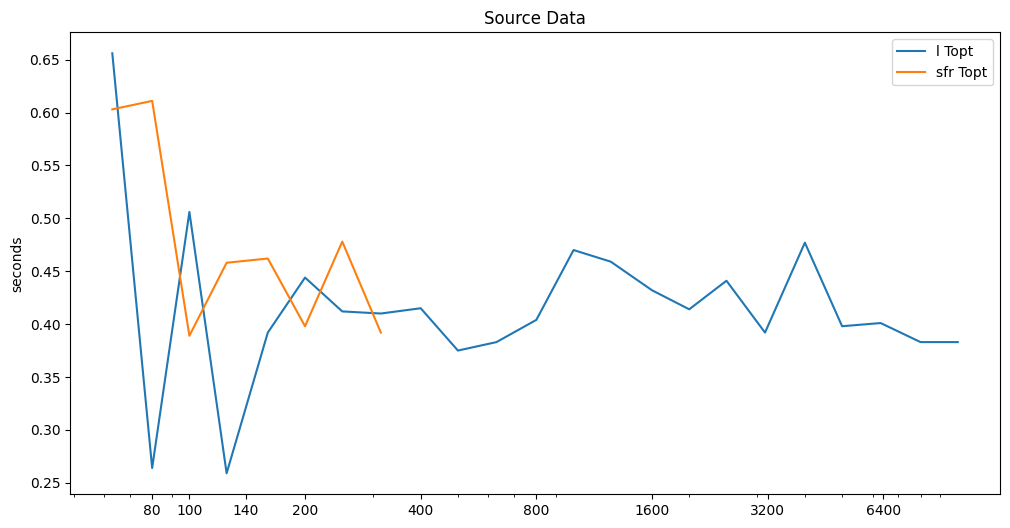

In [6]:
freq_l, _, Topt_l = rew_rt60(
    "../media-room/data/2024-04-16_screen/RT60_screen-p1-l.txt"
)
freq_sfr, _, Topt_sfr = rew_rt60(
    "../media-room/data/2024-04-16_screen/RT60_screen-p1-srf.txt"
)

ax = plot(
    freq_l,
    {
        "l Topt": (freq_l, Topt_l),
        "sfr Topt": (freq_sfr, Topt_sfr),
    },
    title="Source Data",
)
ax.set_ylabel("seconds")
None

In [7]:
# the sweep was full range
freq = freq_l
# but the power generated at the lower end by the bookshelves isn't great,
# so take < 160 from the sub and > 160 from left
Topt = np.concatenate((Topt_sfr[:4], Topt_l[4:]))

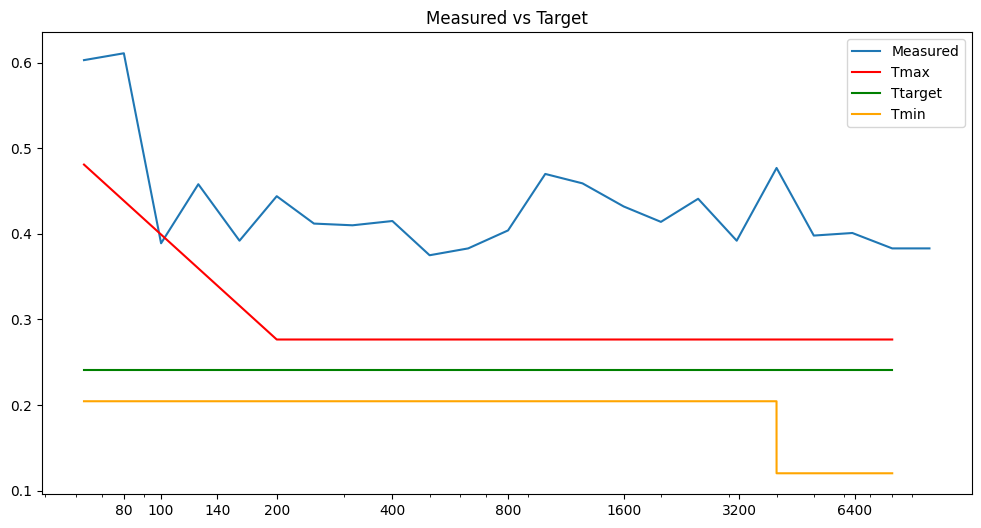

In [8]:
ax = plot(
    freq_l,
    {
        "Measured": (freq, Topt),
        "Tmax": (T_x, Tmax, {"color": "red"}),
        "Ttarget": (T_x, [Tm for _ in T_x], {"color": "green"}),
        "Tmin": (T_x, Tmin, {"color": "orange"}),
    },
    title="Measured vs Target",
)
None

So we're in decent shape, but still have around 200ms to reduce across the whole spectrum. We'll start by calculating the required time reduction for each frequency and then compute the current Sabines of the room, and finally determine the additional Sabines needed to reach the target.

In [9]:
Tneeded = Tm - Topt
Saroom = (0.161 * volume) / Topt
Saneeded = Sarequired - Saroom

print("   freq   Topt Tneeded   Saroom Saneeded")
for fq, tc, tn, sr, sn in zip(freq, Topt, Tneeded, Saroom, Saneeded):
    print(f"{fq:5.0f}Hz {tc:.3f}s {tn:.3f}s {sr:.3f}sa {sn:.3f}sa")

   freq   Topt Tneeded   Saroom Saneeded
   63Hz 0.603s -0.363s 13.751sa 20.731sa
   80Hz 0.611s -0.371s 13.571sa 20.911sa
  100Hz 0.389s -0.149s 21.317sa 13.166sa
  125Hz 0.458s -0.218s 18.105sa 16.377sa
  160Hz 0.392s -0.152s 21.153sa 13.329sa
  200Hz 0.444s -0.204s 18.676sa 15.806sa
  250Hz 0.412s -0.172s 20.127sa 14.356sa
  315Hz 0.410s -0.170s 20.225sa 14.258sa
  400Hz 0.415s -0.175s 19.981sa 14.501sa
  500Hz 0.375s -0.135s 22.112sa 12.370sa
  630Hz 0.383s -0.143s 21.650sa 12.832sa
  800Hz 0.404s -0.164s 20.525sa 13.957sa
 1000Hz 0.470s -0.230s 17.643sa 16.840sa
 1250Hz 0.459s -0.219s 18.066sa 16.417sa
 1600Hz 0.432s -0.192s 19.195sa 15.288sa
 2000Hz 0.414s -0.174s 20.029sa 14.453sa
 2500Hz 0.441s -0.201s 18.803sa 15.679sa
 3150Hz 0.392s -0.152s 21.153sa 13.329sa
 4000Hz 0.477s -0.237s 17.384sa 17.099sa
 5000Hz 0.398s -0.158s 20.835sa 13.648sa
 6300Hz 0.401s -0.161s 20.679sa 13.804sa
 8000Hz 0.383s -0.143s 21.650sa 12.832sa
10000Hz 0.383s -0.143s 21.650sa 12.832sa


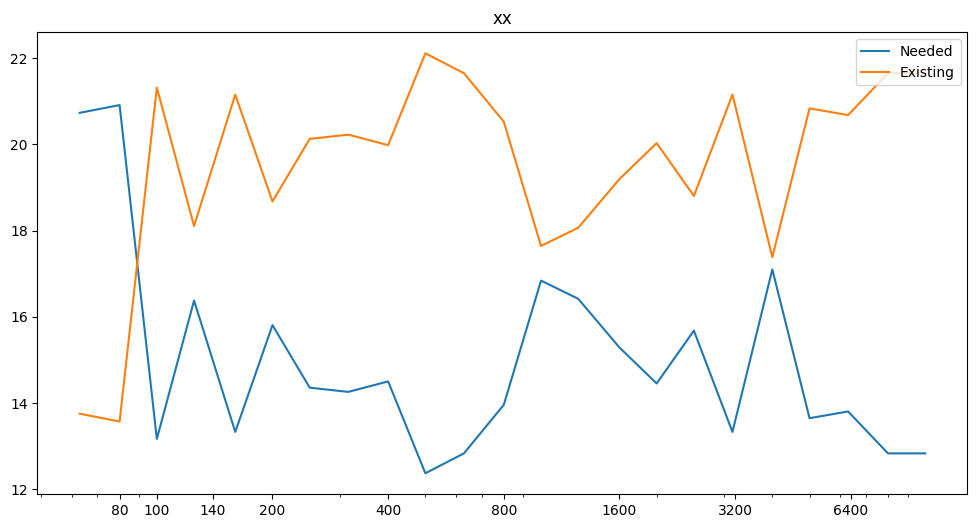

In [10]:
ax = plot(
    freq,
    {
        "Needed": Saneeded,
        "Existing": Saroom,
    },
    title="xx",
)

## Treatment Options

We'll first build up a list of fill options, one or more layers of material, for each of our treatment sizes.

In [11]:
max_options = 99999

fills = defaultdict(list)
for name, width, height, depth, min_air_gap in (
    ("Front", 28.5 * 0.0254, 35.00 * 0.0254, 4.0 * 0.0254, 0 * 0.0254),
    ("Side", 28.5 * 0.0254, 39.75 * 0.0254, 8.0 * 0.0254, 0 * 0.0254),
    ("Back", 28.5 * 0.0254, 51.00 * 0.0254, 12.0 * 0.0254, 0 * 0.0254),
    ("Back Slim", 14.5 * 0.0254, 51.00 * 0.0254, 4.0 * 0.0254, 0 * 0.0254),
    ("Cloud", 24 * 0.0254, 24 * 0.0254, 6.0 * 0.0254, 4 * 0.0254),
):
    for fill, info in materials.items():
        thickness = info["thickness"]
        if thickness > depth:
            continue
        layers = np.floor(depth / thickness)
        air_gap = depth - (thickness * layers)
        a = porous_absorber(
            freq, sigma=info["sigma"], thickness=thickness, air_gap=air_gap
        )
        if layers > 1:
            label = f"{layers}x {fill}"
        else:
            label = fill
        area = width * height
        fills[name].append(
            {
                "label": f"{label} + {air_gap*1000:.0f}mm",
                "a": a,
                "area": area,
                "Sa": area * a,
                "ratio": thickness / depth,
            }
        )

# this isn't stickly necessary, but it sorts each option's fills by the % of the depth filled
# with absorbent and makes looking over the data easier to grok
for name, data in fills.items():
    data.sort(key=lambda d: d["ratio"], reverse=True)
    #
    fills[name] = data[:max_options]

# get rid of the defaultdict now so that we don't accidentally create empty k/v down below
fills = dict(fills)

## Treatment Placements

Next we need to specify all of our treatment slots and provide any additional information about their use, e.g. that we require a slot like the first reflection points to be filled or will be OK with it remaining empty (potentially for later use with a diffuser.)

In [12]:
def enumerate_options(Sa, slots, chosen=[], fill_filter=None):
    if not slots:
        yield chosen, Sa
        return

    # make a copy so that we don't alter the original
    slots = list(slots)
    slot_name, slot_data = slots.pop(0)
    fill_options = fills[slot_data["fills"]]
    count = slot_data["count"]
    for fill in fill_options:
        label = fill["label"]
        if fill_filter and not fill_filter(fill):
            continue
        yield from enumerate_options(
            Sa + (count * fill["Sa"]),
            # pass along the remaining slots that need to be chosen from
            slots,
            chosen + [(slot_name, f"{count} - {label}")],
            fill_filter=fill_filter,
        )

In [13]:
def fit(slots, fill_filter=None):
    count = 0
    best_fit = 999999
    best = None
    for chosen, Sa in enumerate_options(Saroom, slots.items(), fill_filter=fill_filter):
        count += 1
        fit = np.linalg.norm(Sarequired - Sa)
        if fit < best_fit:
            best = {
                "fit": fit,
                "chosen": chosen,
                "Sa": Sa,
                "Tm": 0.161 * volume / Sa,
            }
            best_fit = fit
    return best, count

In [14]:
best = {}

config = {
    "FR": {
        # primary first reflection require an absorber on both sides
        "fills": "Front",
        "count": 2,  # left & right
    },
    "Front": {
        "fills": "Front",
        "count": 4,  # 2 high left, 2 high right
    },
    # Side
    "Side": {
        "fills": "Side",
        "count": 2,
    },
    # Back
    "Back": {
        "fills": "Back",
        "count": 1,
    },
    # Back Slim
    "Back Slim": {
        "fills": "Back Slim",
        "count": 1,
    },
    # Cloud - these are big and divided into small cells to have smaller gaps since they're
    # horizontally oriented. We'll keep them symetrical across the center of the room
    "Cloud 1": {
        "fills": "Cloud",
        "count": 6,
    },
    "Cloud 2": {
        "fills": "Cloud",
        "count": 6,
    },
}


def all(fill):
    return True


def owens_corning(fill):
    label = fill["label"]
    # these are the materials i already have some of
    return "OC Fire & Sound Plus R-15" in label or "OC EcoTouch R-34.2*" in label


def rockwool_and_jm(fill):
    label = fill["label"]
    # these are the materials i already have some of
    return 'RW Safe n Sound 3"' in label or "JM R-30" in label


for name, fill_filter in (
    ("all", all),
    ("owens corning", owens_corning),
    ("rockwool_and_jm", rockwool_and_jm),
):
    best[name], count = fit(config, fill_filter=fill_filter)
    print(f"{count} configurations evaluated for {name}")

2729376 configurations evaluated for all
1 configurations evaluated for owens corning
2 configurations evaluated for rockwool_and_jm


# Results

So this is super interesting. If you look at the performance of RW Safe n Sound 3" and OC Fire & Sound Plus R-15 for 4" treatments in the rigid-backed-porous-absorber notebook you can see that the Rockwool has more absorption in the midrange and the Owens Corning is weaker there, but extends a bit further down in frequency. It gets even more complicated when air gaps are involved. Comparing all possible fills to runs where we're restricting things to Owens Corning or Rockwool results in a non-negligible modeled differences from 400Hz down once the differences are combined across a number of devices. 

For thinner devices higher flow resistivity is preferable, but thicker devices beenfit from lower resistivity materails, but air gaps complicate this even further. See the thickness-and-flow-resistivity notebook for more on this.

It would be interesting to compare all of this with real world tests, but that would involve buying 3x the required materials and the stuff is pretty messying to work with so swapping it in/out would be less than idea. Mostly planning to go with what's predicated as optimal here, the 'all' case. There will be plenty of incremental testing as things are built & placed.

Note: Unfortunately there is a dearth of quality flow resistivity numbers for available "pink" fiberglass insulation. So it's unlikely the material used will exactly match that picked in calculations here.

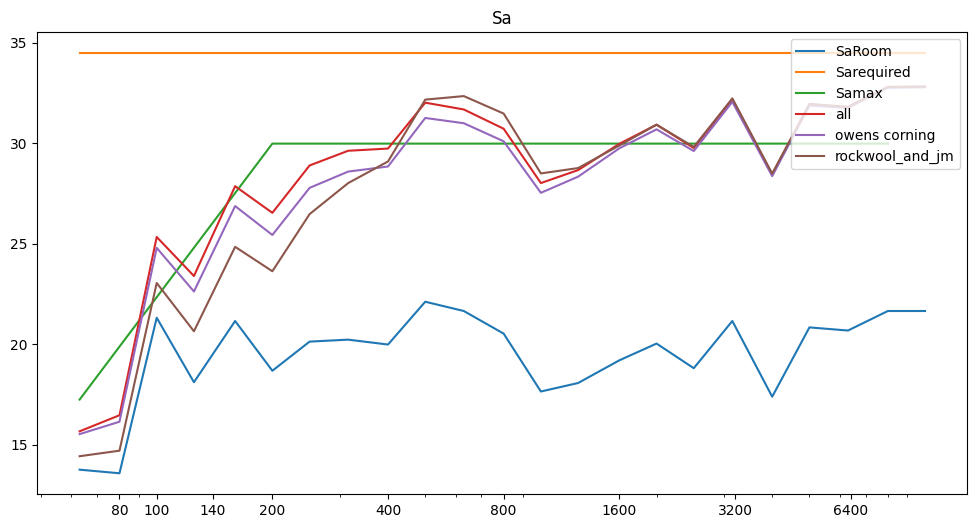

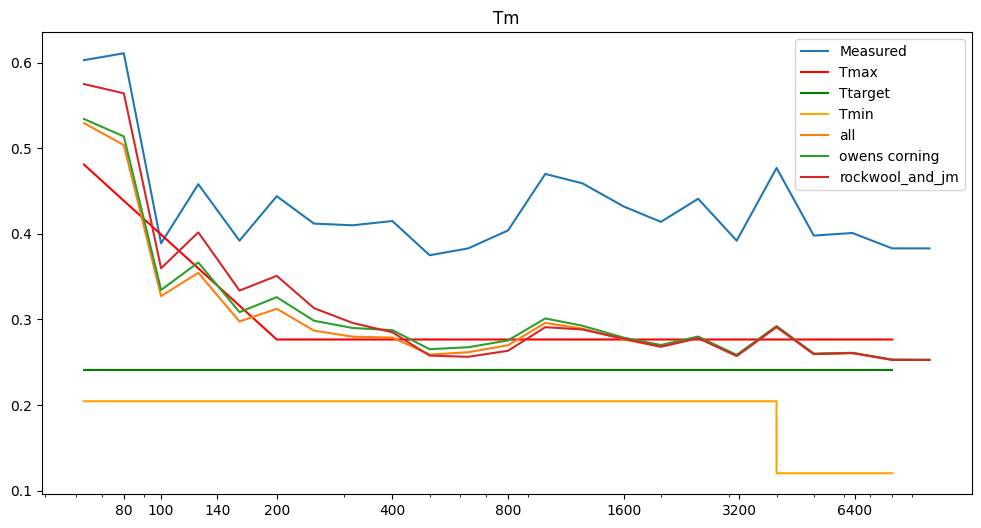

In [15]:
ax = plot(
    freq,
    dict(
        {
            "SaRoom": Saroom,
            "Sarequired": [Sarequired for _ in freq],
            "Samax": (T_x, (0.161 * volume) / np.array(Tmax)),
        },
        **{n: b["Sa"] for n, b in best.items()}
    ),
    title="Sa",
)
ax = plot(
    freq_l,
    dict(
        {
            "Measured": (freq, Topt),
            "Tmax": (T_x, Tmax, {"color": "red"}),
            "Ttarget": (T_x, [Tm for _ in T_x], {"color": "green"}),
            "Tmin": (T_x, Tmin, {"color": "orange"}),
        },
        **{n: b["Tm"] for n, b in best.items()}
    ),
    title="Tm",
)
None

Per https://www.aes.org/technical/documents/AESTD1001.pdf adjacent octave bands should be ±5%, this doesn't take into account the allowed rise below 200Hz. Excepting that we'd be in good shape there.

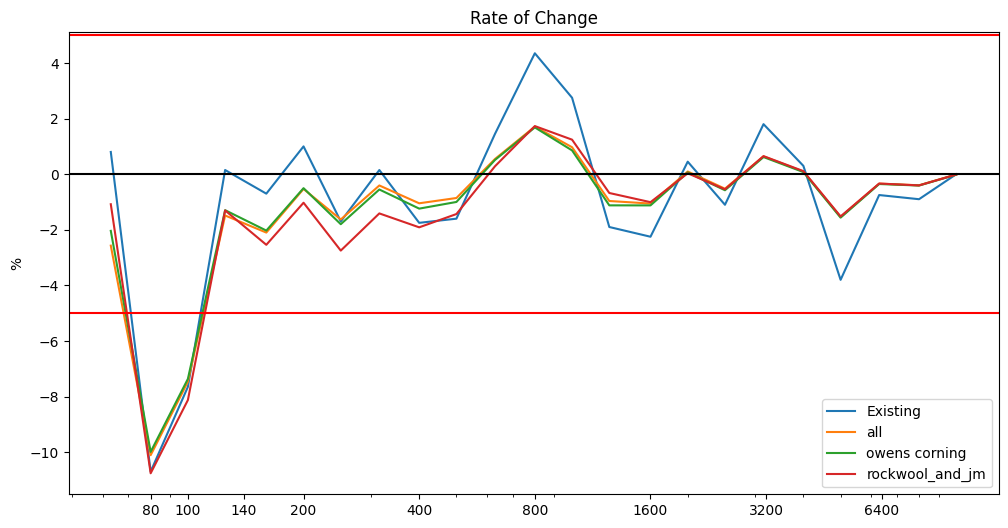

In [16]:
ax = plot(
    freq,
    dict(
        {
            "Existing": np.gradient(Topt) * 100,
        },
        **{n: np.gradient(b["Tm"]) * 100 for n, b in best.items()}
    ),
    title="Rate of Change",
    loc="lower right",
)
ax.set_ylabel("%")
ax.axhline(5, color="red")
ax.axhline(0, color="black")
ax.axhline(-5, color="red")
None

In [17]:
pprint(best)

{'all': {'Sa': array([15.66105704, 16.4599774 , 25.33542398, 23.39380845, 27.86498439,
       26.53877977, 28.89741205, 29.62848266, 29.73874618, 32.02384794,
       31.68492275, 30.72573763, 28.02086352, 28.66644288, 29.97411361,
       30.92634702, 29.765787  , 32.17807043, 28.45441082, 31.94098846,
       31.80932539, 32.80044823, 32.81329028]),
         'Tm': array([0.52947457, 0.50377538, 0.32729397, 0.35445838, 0.29758249,
       0.31245338, 0.28695066, 0.27987027, 0.27883258, 0.25893614,
       0.26170591, 0.26987575, 0.29592705, 0.28926266, 0.27664309,
       0.26812515, 0.27857928, 0.25769511, 0.29141814, 0.25960785,
       0.2606824 , 0.25280543, 0.25270649]),
         'chosen': [('FR', '2 - OC Fire & Sound Plus R-15 + 13mm'),
                    ('Front', '4 - OC Fire & Sound Plus R-15 + 13mm'),
                    ('Side', '2 - RW Safe n Sound 6" + 51mm'),
                    ('Back', '1 - JM R-30 + 44mm'),
                    ('Back Slim', '1 - OC Fire & Sound Plus R-15 + 